# Notes for the script $\textit{ efficiency_variance.py}$

## Introduction

The aim of the script is to check the variation of the turbine efficiency for three cases:

- A correlation between temperatures $T_1$ and $T_2$ exists and the value of the related
coefficient has been changed over a range between $[0.0;1.0]$. Pressures are not correlated.

- A Correlation between pressures $P_1$ and $P_2$ exists and the range of their correlation coefficient has been set similarly to the previous case. Temperatures are nor correlated.

- A Correlation between temperatures $T_1$, $T_2$ exists and also between pressures $P_1$, $P_2$; their coefficient has been set according to che $for$ statement reported in Section 2. 

The turbine efficiency has been checked using two different set of points:

- A set of points obtained by applying the quadratures rule and correlating them with the inverse Nataf transformation;

- A set of samples from the original space by using Monte Carlo.

## Section 1: Calculation of the points sets.

In the first part of the script a function renamed $\textit{blackbox}$ has been written to calculate the turbine efficiency using four input constant values (a couple of temperatures and a couple of pressures).

In [6]:
import numpy as np
from equadratures import *
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# --------------------------------------------------------------------------------------------------------------------
#
# EFFICIENCY DEFINITION
#
#---------------------------------------------------------------------------------------------------------------------
def blackbox(t1, t2, p1, p2):
    """ Efficiency definition:
        numerator and denominator
        have been devided by Cp,
        assumed as a constant.
    """
    eta       = (t1 - t2) / (t1 * (1 - (p2/p1)**(0.4/1.4)))
    return eta

### Application of Inverse Nataf transformation

In the following lines a function to do an instance to Nataf class has been done; the input parameter is represented by the correlation matrix $R$, which off-diagonal elements will be changed in each $for$ statement.
The object created uses the methods:

- $\textit{U2C}$ to correlate points obtained with a quadrature rule
- $\textit{getCorrelatedSamples}$ to correlate points sampled with Monte Carlo.

The calculation of the mean and the variance of the turbine efficiency is reported at the end of the function.

In [12]:
# -----------------------------------------------------------------------------------------------------------
# Nataf application
#---------------------------------------------------------------------------------------------------------------------
def apply_nataf(R):
    obj = Nataf([M[0], M[1], M[2], M[3]], R)
                                                                  
    pc = obj.U2C(p)
    mc_pts = obj.getCorrelatedSamples(N=3000)
                                                                  
    results = blackbox(pc[:,0], pc[:,1], pc[:,2], pc[:,3])
    results_mc = blackbox(mc_pts[:,0], mc_pts[:,1], mc_pts[:,2], mc_pts[:,3])
    standardPoly.computeCoefficients(results)
    myStats = standardPoly.getStatistics()
                                                                  
    print '==============EQ==============='
    print 'mean', myStats.mean * 100
    print '2-sigma', np.sqrt(myStats.variance) * 1.96
                                                                  
    print '==============MC==============='
    print 'mean', np.mean(results_mc)* 100
    print '2-sigma', np.sqrt(np.var(results_mc)) * 1.96

    varEQ  = np.sqrt(myStats.variance)*1.96
    varMC = np.sqrt(np.var(results_mc))*1.96
    
    return varMC, varEQ

### Function to plot results 

Two kind of plot will be proposed: $\textit{plot2d}$ will be used to show results for the case in which a correlation exist between temperatures but not for pressures and vice versa.

The function $\textit{plot3d}$ will be used for the last case: two surfaces will be generated (the first for quadrature points set and the second for the Monte Carlo samples) as function of the correlation coefficient values for temperatures and pressures.

In [17]:
def plot2d(R_array, eta_arrayMC, eta_arrayEQ, param):
     plt.figure()
     plt.grid(linewidth=0.5, color='k')
     plt.plot(R_array, eta_arrayMC, 'ro-', label='MonteCarlo')
     plt.plot(R_array, eta_arrayEQ, 'bo-', label='EffectQuad')
     plt.legend(loc='upper right')
     plt.title(param)
     plt.xlabel(r'$\rho$ correlation coefficient')
     plt.ylabel(r'2 $\sigma$ of $\eta$ turbine efficiency')
     plt.xticks(R_array)
     plt.show()

def plot3d(R_array_X, R_array_Y, eta_arrayMC, eta_arrayEQ, param):
   
    fig = plt.figure()
    ax  = plt.axes(projection='3d')
    ax.plot_trisurf(R_array_X, R_array_Y, eta_arrayMC, cmap='viridis', edgecolor='b')
    ax.plot_trisurf(R_array_X, R_array_Y, eta_arrayEQ, cmap='magma', edgecolor='r')
    ax.set_xlabel(r'$\rho$ temperatures')
    ax.set_ylabel(r'$\rho$ pressures')
    ax.set_zlabel(r'2 $\sigma$ of $\eta$ turbine efficiency')
    plt.show()

#

## Section 2: $\textit{for}$ statement

In the last part of the script a $\textit{for}$ statement has been used to check the three cases listed in the introduction.

Four truncated-gaussian distributions has been created using the mean values of temperaures and pressures; the quadrature rule has been used to generate few samples in the uncorrelated space.


In [18]:
# --------------------------------------------------------------------------------------------------------------------
#
# INPUTS
#
#---------------------------------------------------------------------------------------------------------------------
gamma = 1.4
T01   = 800.
T02   = 700.
P01   = 10*10**5
P02   = 5*10**5

M = list()

M.append(Parameter(order=5, distribution='truncated-gaussian', shape_parameter_A= T01, shape_parameter_B=1.0, upper = T01*1.1, lower = T01*0.95))
M.append(Parameter(order=5, distribution='truncated-gaussian', shape_parameter_A= T02, shape_parameter_B=1.0, upper = T02*1.1, lower = T02*0.95))
M.append(Parameter(order=5, distribution='truncated-gaussian', shape_parameter_A= P01, shape_parameter_B=1.0, lower = P01*0.90, upper = P01*1.1))
M.append(Parameter(order=5, distribution='truncated-gaussian', shape_parameter_A= P02, shape_parameter_B=1.0, lower = P02*0.90, upper = P02*1.1))

# --------------------------------------------------------------------------------------------------------------------
#
# POLYNOMIAL CONSTRUCTION
#
#---------------------------------------------------------------------------------------------------------------------
# Construct a polynomial in the uncorrelated normal space
myBasis = Basis('Tensor grid')
normal = Parameter(order=5, distribution='gaussian', shape_parameter_A=0.0, shape_parameter_B=1.0)
standardPoly = Polyint([normal, normal, normal, normal], myBasis)
p = standardPoly.quadraturePoints


The correlation matrix $R$ changes in each $for$  loop: in the following lines the initialization of the first matrix has been written, together with the definition of the arrays $\textit{eta_arrayMC}$ that will contain all the turbine efficiency values obtained by varying $R$ and $\textit{eta_arrayEQ}$ that will contain all the similar values for the quadrature points.

The three main cases under study have been distinguished with the definition of three strings, which indicate the correlated quantities in the $i^{th}$ loop.

In [19]:
R = np.identity(len(M))
R_array = [i*.1 for i in range(10)]
eta_arrayMC = np.zeros(len(R_array))
eta_arrayEQ = np.zeros(len(R_array))

cases_of_correlation = ('temperatures', 'pressures', 'both')
correlation_matrix = list()

The following statement verifies the values into the array of strings and, depending on their actual values, calculates a new correlation matrix (it is valid only inside the $i^{th}$ loop). The actual value of turbine efficiency is stored into the arrays $\textit{eta_arrayMC}$ and $\textit{eta_arrayEQ}$ and finally, once the for loop has finished, the turbine efficiency as function of all the off-diagonal elements of $R$  is plotted.
A similar procedure has been followed for the case in which pressures are correlated.
The last figure displays the variation of efficiency by varying both the correlation between temperatures and between pressures. The smooth, red surface represents the variation related to quadrature points, while the jagged green surface displays the behaviour using MonteCarlo samples.

The Cholesky decomposition of fictive matrix R0 is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
The fictive matrix is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
==============EQ===============
mean 69.5733061494
2-sigma 0.018119844315431514
==============MC===============
mean 69.60647074070855
2-sigma 0.018386420271758724
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.1        0.99498744 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
The fictive matrix is:
[[1.  0.1 0.  0. ]
 [0.1 1.  0.  0. ]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
==============EQ===============
mean 69.5733931174
2-sigma 0.01719843919506913
==============MC===============
mean 69.58439927539081
2-sigma 0.017228767246665323
The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.2       0.9797959 0.        0.      

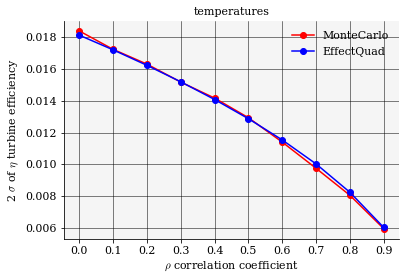

The Cholesky decomposition of fictive matrix R0 is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
The fictive matrix is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
==============EQ===============
mean 69.5733061494
2-sigma 0.018119844315431514
==============MC===============
mean 69.56094231519127
2-sigma 0.018213250191101656
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.1        0.99498744]]
The fictive matrix is:
[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.1 1. ]]
==============EQ===============
mean 69.5733061493
2-sigma 0.018119844280481495
==============MC===============
mean 69.56924810991929
2-sigma 0.018853323089146452
The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.        1.        0.        0.     

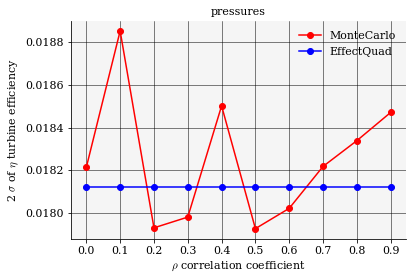

The Cholesky decomposition of fictive matrix R0 is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
The fictive matrix is:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
==============EQ===============
mean 69.5733061494
2-sigma 0.018119844315431514
==============MC===============
mean 69.56320759842177
2-sigma 0.01789943967392208
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.1        0.99498744]]
The fictive matrix is:
[[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  0.1]
 [0.  0.  0.1 1. ]]
==============EQ===============
mean 69.5733061493
2-sigma 0.018119844280481495
==============MC===============
mean 69.57165782423729
2-sigma 0.018268244416615193
The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.        1.        0.        0.      

==============EQ===============
mean 69.5733931171
2-sigma 0.01719843897414919
==============MC===============
mean 69.56338696142184
2-sigma 0.017186420524827002
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.1        0.99498744 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.69999996 0.71414288]]
The fictive matrix is:
[[1.         0.1        0.         0.        ]
 [0.1        1.         0.         0.        ]
 [0.         0.         1.         0.69999996]
 [0.         0.         0.69999996 1.        ]]
==============EQ===============
mean 69.573393117
2-sigma 0.01719843893732911
==============MC===============
mean 69.55745199868525
2-sigma 0.016980591042904208
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.1        0.99498744 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.799

The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.3       0.9539392 0.        0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.2       0.9797959]]
The fictive matrix is:
[[1.  0.3 0.  0. ]
 [0.3 1.  0.  0. ]
 [0.  0.  1.  0.2]
 [0.  0.  0.2 1. ]]
==============EQ===============
mean 69.5735670533
2-sigma 0.01518886107789244
==============MC===============
mean 69.58352923554834
2-sigma 0.01529350245122697
The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.3       0.9539392 0.        0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.3       0.9539392]]
The fictive matrix is:
[[1.  0.3 0.  0. ]
 [0.3 1.  0.  0. ]
 [0.  0.  1.  0.3]
 [0.  0.  0.3 1. ]]
==============EQ===============
mean 69.5735670532
2-sigma 0.015188861036205406
==============MC===============
mean 69.58125105971142
2-sigma 0.015289660936677153
The Cholesky decompositi

==============EQ===============
mean 69.573654021
2-sigma 0.014076900738832297
==============MC===============
mean 69.58410516834104
2-sigma 0.01409676100768049
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.4        0.91651514 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.79998847 0.60001537]]
The fictive matrix is:
[[1.         0.4        0.         0.        ]
 [0.4        1.         0.         0.        ]
 [0.         0.         1.         0.79998847]
 [0.         0.         0.79998847 1.        ]]
==============EQ===============
mean 69.5736540209
2-sigma 0.014076900693860044
==============MC===============
mean 69.57542073655186
2-sigma 0.014126955243361754
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.4        0.91651514 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.89

==============EQ===============
mean 69.5738279572
2-sigma 0.011535792408717459
==============MC===============
mean 69.57392261278483
2-sigma 0.011520308690824368
The Cholesky decomposition of fictive matrix R0 is:
[[1.         0.         0.         0.        ]
 [0.6        0.8        0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.4        0.91651514]]
The fictive matrix is:
[[1.  0.6 0.  0. ]
 [0.6 1.  0.  0. ]
 [0.  0.  1.  0.4]
 [0.  0.  0.4 1. ]]
==============EQ===============
mean 69.5738279571
2-sigma 0.011535792353837799
==============MC===============
mean 69.56639829031226
2-sigma 0.011647430981629734
The Cholesky decomposition of fictive matrix R0 is:
[[1.        0.        0.        0.       ]
 [0.6       0.8       0.        0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.5       0.8660254]]
The fictive matrix is:
[[1.  0.6 0.  0. ]
 [0.6 1.  0.  0. ]
 [0.  0.  1.  0.5]
 [0.  0.  0.5 1. ]]
======

In [ ]:
for j in range(len(cases_of_correlation)):
    
    if cases_of_correlation[j] == 'temperatures':
    
        for i in range (10):
            R[0,1] = i*.1
            R[1,0] = R[0,1]
           
            res = apply_nataf(R)
                                                                              
            eta_arrayMC[i] = res[0]
            eta_arrayEQ[i] = res[1]
   
        plot2d(R_array, eta_arrayMC, eta_arrayEQ, cases_of_correlation[j])


    if cases_of_correlation[j] == 'pressures':   
        R = np.identity(len(M))
        for i in range(10):
            R[2,3] = i*.1
            R[3,2] = R[2,3]
           
            res = apply_nataf(R)
                                                                              
            eta_arrayMC[i] = res[0]
            eta_arrayEQ[i] = res[1]
   
        plot2d(R_array, eta_arrayMC, eta_arrayEQ, cases_of_correlation[j])

    
    if cases_of_correlation[j] == 'both':
        number_of_rho_values = 10
        square_value = int(number_of_rho_values**2)

        eta_arrayMC_var = np.zeros((square_value))
        eta_arrayEQ_var = np.zeros((square_value))
        R_array_X = np.zeros(square_value) 
        R_array_Y = np.zeros(square_value)
        for i in range(number_of_rho_values):
            for k in range(number_of_rho_values):
                R[0,1] = i*.1
                R[1,0] = R[0,1]
                R[2,3] = k*.1
                R[3,2] = R[2,3]
                               
                res = apply_nataf(R)
                #print 'i:',i, 'k:',k
                index = int(i*number_of_rho_values +k)
                eta_arrayMC_var[index] = res[0]
                eta_arrayEQ_var[index] = res[1]
                R_array_X[index] = (i*.1)
                R_array_Y[index] = (k*.1)
                #print 'index now:' , index

        #print 'R_array_X:'
        #print R_array_X
        #print 'R_array_Y'
        #print R_array_Y
        
        plot3d(R_array_X, R_array_Y, eta_arrayMC_var, eta_arrayEQ_var, cases_of_correlation[j])